## Pricing a European Call Option under Risk Neutrality

#### Written for the QuantEcon Indian Summer Workshop (August 2022)
#### Author: [John Stachurski](http://johnstachurski.net/)

In [8]:
import numpy as np
import matplotlib.pyplot as plt

We are going to price a European call option under the assumption of risk neutrality.  The price satisfies


$$ P = \beta^n \mathbb E \max\{ S_n - K, 0 \} $$

where

1. $\beta$ is a discount factor,
2. $n$ is the expiry date,
2. $K$ is the strike price and
3. $\{S_t\}$ is the price of the underlying asset at each time $t$.

(For example, if the call option is to buy stock in Amazon at strike price $K$, the owner has the right to buy 1 share in Amazon at price $K$ after $n$ days.  The price is the expectation of the return $\max\{S_n - K, 0\}$, discounted to today's value.)

### Exercise 1

Suppose that $S_n$ has the [log-normal](https://en.wikipedia.org/wiki/Log-normal_distribution) distribution with parameters $\mu$ and $\sigma$.  Let $f$ denote the density of this distribution.  Then

$$ P = \beta^n \int_0^\infty \max\{x - K, 0\} f(x) dx $$

1. Plot the function 

$$g(x) = \beta^n  \max\{x - K, 0\} f(x)$$ 

over the interval $[0, 1000]$ when $\mu=5$, $\sigma=2$, $\beta=0.99$, $n=10$ and $K=10$.

2. Using the [quad](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html) function from SciPy, compute the price $P$.

### Solution

First let's do the plot.

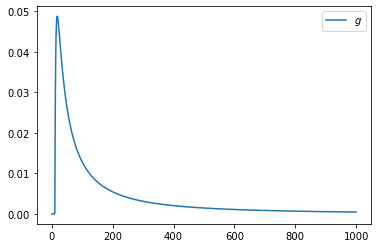

In [9]:
from scipy.integrate import quad
from scipy.stats import lognorm

μ, σ, β, n, K = 5, 2, 0.99, 10, 10

def g(x):
    return β**n * np.maximum(x - K, 0) * lognorm.pdf(x, σ, loc=μ)

x_grid = np.linspace(0, 1000, 1000)
y_grid = [g(x) for x in x_grid]

fig, ax = plt.subplots()
ax.plot(x_grid, y_grid, label="$g$")
ax.legend()
plt.show()

The integral and hence the price is

In [10]:
quad(g, 0, 100_000)

(4.955035450241542, 6.283748349991607e-08)

The first value is the integral, which is approximate, and the second is an estimate of the error in the approximation.

### Exercise 2

A common model for $\{S_t\}$ is

$$ \ln \frac{S_{t+1}}{S_t} = \mu + \sigma \xi_{t+1} $$

where $\{ \xi_t \}$ is IID and standard normal.  However, its predictions are in some ways counterfactual.  For example, volatility is not stationary but rather changes over time.  Here's an improved version:

$$ \ln \frac{S_{t+1}}{S_t} = \mu + \sigma_t \xi_{t+1} $$

where 

$$ 
    \sigma_t = \exp(h_t), 
    \quad
        h_{t+1} = \rho h_t + \nu \eta_{t+1}
$$

Here $\{\eta_t\}$ is also IID and standard normal.

Write a function that simulates the sequence $S_0, \ldots, S_n$, where the parameters are set to 

In [11]:
μ = 0.001
ρ = 0.1
ν = 0.0001
S0 = 10
h0 = 0
n = 20


(Here `S0` is $S_0$ and `h0` is $h_0$.)

### Solution 

In [12]:
from numpy.random import randn

def simulate_asset_price_path(μ=0.001,
                               S0=10,
                               h0=0,
                               n=20,
                               ρ=0.1,
                               ν=0.0001):
    s = np.empty(n+1)
    s[0] = np.log(S0)

    h = h0
    for t in range(n):
        s[t+1] = s[t] + μ + np.exp(h) * randn()
        h = ρ * h + ν * randn()
        
    return np.exp(s)

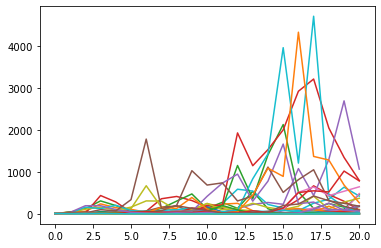

In [13]:
fig, ax = plt.subplots()

for i in range(50):
    path = simulate_asset_price_path()
    ax.plot(path)
plt.show()

### Exercise 3

Compute the price of the option $P_0$ by Monte Carlo, averaging over realizations $S_n^1, \ldots, S_n^M$ of $S_n$ and appealing to the law of large numbers:

$$ \mathbb E \max\{ S_n - K, 0 \} 
    \approx
    \frac{1}{M} \sum_{m=1}^M \max \{S_n^m - K, 0 \}
    $$
    
Use the values given below:

In [14]:
M = 100_000
K = 100
n = 20
β = 0.95

### Solution

In [15]:
S_vals = np.empty(M)
for i in range(M):
    S_vals[i] = simulate_asset_price_path()[-1]
    
P = β**n * np.mean(np.maximum(S_vals - K, 0))


### Exercise 4

To the extend that you can, write faster, more efficient code to compute the option price.  

In particular, try to speed up the code above using `jit` or `njit` from Numba.  

(To learn about Numba, you can read [this lecture](https://python-programming.quantecon.org/numba.html).)

Increase the value of $M$ to 10,000,000.

### Solution

In [23]:
from numba import njit, prange

In [24]:
@njit
def compute_call_price(β=0.95,
                       μ=0.001,
                       S0=10,
                       h0=0,
                       K=100,
                       n=20,
                       ρ=0.1,
                       ν=0.0001,
                       M=10_000_000):
    current_sum = 0.0
    for m in range(M):
        s = np.log(S0)
        h = h0
        for t in range(n):
            s = s + μ + np.exp(h) * randn()
            h = ρ * h + ν * randn()
        current_sum += np.maximum(np.exp(s) - K, 0)
        
    return β**n * current_sum / M

In [25]:
%%time 
compute_call_price()

CPU times: user 8.57 s, sys: 3.94 ms, total: 8.57 s
Wall time: 8.56 s


65565.71647067544

### Exercise 5

If you can, use `prange` from Numba to parallelize this code and make it even faster.

### Solution

In [26]:
@njit(parallel=True)
def compute_call_price_parallel(β=0.95,
                                   μ=0.001,
                                   S0=10,
                                   h0=0,
                                   K=100,
                                   n=20,
                                   ρ=0.1,
                                   ν=0.0001,
                                   M=10_000_000):
    current_sum = 0.0
    for m in prange(M):
        s = np.log(S0)
        h = h0
        for t in range(n):
            s = s + μ + np.exp(h) * randn()
            h = ρ * h + ν * randn()
        current_sum += np.maximum(np.exp(s) - K, 0)
        
    return β**n * current_sum / M

In [27]:
%%time
compute_call_price_parallel()

CPU times: user 14.9 s, sys: 0 ns, total: 14.9 s
Wall time: 1.11 s


60054.328314303195